# ACP Project - Predicting Critical Events 

## Setup

In [159]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 300)

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

import shap
shap.initjs()

%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [160]:
class Notebook:
    OUTCOME = "CriticalEvent"



In [170]:
from utils.evaluation import f2_score, METRICS, ISOLATION_METRICS, evaluate, evaluate_from_pred
%aimport utils.evaluation

## Summary of results (*pre-tuning*)

See following sections for detailed results on each model, and the improvement achieved after tuning model parameters.

In [162]:
pd.read_csv("old_code/ml_test_4/results.csv").drop("dataset", axis=1).set_index(
    "model"
).sort_values("test_F2 Score", ascending=False)



,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
XGB_OverUnder,19.782670,0.217722,0.958343,0.242830,0.684967,0.928427,0.358157,0.501435
XGB_Undersampling,4.260071,0.252587,0.958586,0.242177,0.671895,0.928159,0.354915,0.493959
LightGBM Weighted,7.850628,0.281921,0.966453,0.279089,0.610458,0.920652,0.381660,0.491394
LightGBM Balanced,11.450883,0.296697,0.959249,0.241540,0.650980,0.921191,0.351287,0.484377
LightGBM_SMOTE,6.433458,0.485369,0.951205,0.207203,0.661438,0.918630,0.314806,0.458349
LightGBM_SMOTE-Tomek,166.768970,0.531246,0.950519,0.204260,0.665359,0.919373,0.312320,0.457903
Random Forest_Undersampling,8.273318,2.149415,0.979337,0.404654,0.469281,0.930955,0.433802,0.454188
Random Forest_OverUnder,18.818681,1.158192,0.977613,0.370047,0.461438,0.929532,0.409668,0.438891
XGB_SMOTE,27.642934,0.214651,0.975801,0.341724,0.462745,0.909791,0.391558,0.430784


## Training Setup

The following code helps train and evaluate the models in a standardised way.

### Test Harness

In [163]:
from sklearn.model_selection import train_test_split


def train_test_split_oneclass(*frames, label, test_size=0.25, random_state=42):
    """ Split DataFrames or Series into random train and test subsets, such that the train subset has no positive instances
    """
    X = frames[0]
    label = label.reset_index(drop=True)
    train_idx, test_idx = train_test_split(
        label[~label].index, test_size=test_size, random_state=random_state
    )
    test_idx = np.concatenate([test_idx, label[label].index])

    return tuple(__ for _ in frames for __ in (_.iloc[train_idx], _.iloc[test_idx]))


def train_test_split_notna(*frames, test_size=0.25, random_state=42):
    """ Split DataFrames or Series into random train and test subsets, such that the test subset contains no NaN values.
    """
    X = frames[0]
    mask = ~X.reset_index(drop=True).isna().any(axis=1)
    sub_size = test_size * X.shape[0] / mask.sum()

    rem_idx, test_idx = train_test_split(
        mask[mask].index, test_size=sub_size, random_state=random_state
    )
    rem_idx = np.concatenate([rem_idx, mask[~mask].index])

    return tuple(__ for _ in frames for __ in (_.iloc[rem_idx], _.iloc[test_idx]))


In [164]:
from collections import defaultdict
from sklearn.model_selection import cross_validate
from sklearn.base import clone as clone_estimator


def spotCheckDatasets(
    models,
    datasets,
    cv=3,
    set_params={},
    order=["dataset", "model"],
    fit_params={},
    scoring=METRICS,
):
    """ Run stratified k-fold cross-validation on the given models over the given dataset variants
        :param models: Single estimator or dict of the format {'Model Name': model}
        :param datasets: Single tuple (X, y) or dict of the format {'Dataset name': (X, y)}
        :param set_params: Hook to set model parameters based on each dataset. Callable of type function(X, y) -> Dict
    """

    models = {"Model": models} if type(models) != dict else models
    datasets = {"Data": datasets} if type(datasets) != dict else datasets

    param_callables = defaultdict(lambda: lambda X, y: dict())
    param_callables.update(set_params)

    fit_param_dict = defaultdict(lambda: dict())
    fit_param_dict.update(fit_params)

    tests = [
        (
            datakey,
            (X, y),
            modelkey,
            clone_estimator(model).set_params(**(param_callables[modelkey](X, y))),
            fit_param_dict[modelkey],
        )
        for datakey, (X, y) in datasets.items()
        for modelkey, model in models.items()
    ]

    return (
        pd.concat(
            (
                pd.DataFrame.from_dict(
                    cross_validate(
                        model,
                        X=X,
                        y=y,
                        cv=cv,
                        scoring=scoring,
                        n_jobs=-1,
                        fit_params=fitparams,
                    )
                ).assign(dataset=datakey, model=modelkey)
                for datakey, (X, y), modelkey, model, fitparams in tests
            )
        )
        .groupby(["dataset", "model"])
        .mean()
    )


def spotCheckCV(models, X, y, cv=3, fit_params={}, scoring=METRICS):
    """ Run stratified k-fold cross-validation on the given models
    """
    return spotCheckDatasets(
        models, (X, y), fit_params=fit_params, scoring=scoring
    ).loc["Data"]


def spotCheckParams(model, X, y, cv=3, fit_params={}, scoring=METRICS):
    """ For more specialised models, run stratified k-fold cross-validation with fit-params
    """

    return (
        pd.DataFrame.from_dict(
            cross_validate(
                model,
                X=X,
                y=y,
                cv=cv,
                scoring=METRICS,
                n_jobs=-1,
                fit_params=fit_params,
            )
        )
        .assign(model="Model")
        .groupby("model")
        .mean()
    )


In [165]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.base import clone as clone_estimator


def with_sampling_strategies(clf, clf_name="Classifier", categorical_cols_idx=[]):
    smote = (
        SMOTENC(categorical_features=categorical_cols_idx)
        if categorical_cols_idx
        else SMOTE()
    )

    return {
        f"{clf_name}_Undersampling": ImbPipeline(
            steps=[
                ("undersampling", RandomUnderSampler(sampling_strategy=0.1)),
                (clf_name, clone_estimator(clf)),
            ]
        ),
        f"{clf_name}_SMOTE": ImbPipeline(
            steps=[("smote", clone_estimator(smote)), (clf_name, clone_estimator(clf))]
        ),
        f"{clf_name}_OverUnder": ImbPipeline(
            steps=[
                ("smote", clone_estimator(smote).set_params(sampling_strategy=0.1)),
                ("undersampling", RandomUnderSampler(sampling_strategy=0.5)),
                (clf_name, clone_estimator(clf)),
            ]
        ),
        f"{clf_name}_SMOTE-Tomek": ImbPipeline(
            steps=[
                ("smote", clone_estimator(smote).set_params(sampling_strategy="auto")),
                ("tomek", TomekLinks(sampling_strategy="all")),
                (clf_name, clone_estimator(clf)),
            ]
        ),
    }


## Dataset

Different variations on this initial, pre-processed version will be tested throughout.

In [166]:
from dataset import SCIData, SCICols
%aimport dataset

#SCIData.load('data/sci.h5').clean_all().filter_vague_diagnoses().derive_readmission().omit_vbg()
sci = SCIData.load('data/sci_processed_2.h5').fix_readmissionband().derive_critical_event(within=2)

FileNotFoundError: File data/sci_processed_2.h5 does not exist

## Logistic Regression (NEWS only)

Logistic regression (L2 penalty, by default) slightly beats the baseline NEWS model, which had AUC `0.807` for this outcome, but doesn't beat the original study score of `0.873`.

Balanced variant completely flips the precision vs. recall relationship, so it does a better job of minimising false-negatives. However, the final values are still low.

In [8]:
from sklearn.linear_model import LogisticRegression

datasets_lr = {
    "Raw NEWS": sci.mandate(SCICols.news_data_raw).xy(
        outcome=Notebook.OUTCOME, x=SCICols.news_data_raw, dtype=float
    ),
    "Scored NEWS": sci.mandate(SCICols.news_data_scored).xy(
        outcome=Notebook.OUTCOME, x=SCICols.news_data_scored, dtype=float
    ),
}

models = {
    "LR": LogisticRegression(max_iter=1000, random_state=42),
    "LR Balanced": LogisticRegression(
        class_weight="balanced", max_iter=1000, random_state=42
    ),
}

spotCheckDatasets(models, datasets_lr)


fit_time  score_time  test_Accuracy  test_Precision  \
dataset     model                                                              
Raw NEWS    LR           1.357369    0.079839       0.984029        0.585566   
            LR Balanced  0.869662    0.082779       0.862873        0.078060   
Scored NEWS LR           0.211435    0.084122       0.983853        0.543242   
            LR Balanced  0.183843    0.092434       0.858794        0.076380   

                         test_Recall  test_AUC  test_F1 Score  test_F2 Score  
dataset     model                                                             
Raw NEWS    LR              0.057346  0.817302       0.102924       0.069666  
            LR Balanced     0.663341  0.816260       0.139240       0.263397  
Scored NEWS LR              0.051167  0.813106       0.092838       0.062354  
            LR Balanced     0.673125  0.814827       0.136870       0.261209

In [9]:
spotCheckCV(
    {
        "LR": LogisticRegression(max_iter=1000, random_state=42),
        **with_sampling_strategies(
            LogisticRegression(max_iter=1000, random_state=42), "LR"
        ),
    },
    *datasets_lr["Raw NEWS"]
)



,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
LR,1.394936,0.078124,0.984029,0.585566,0.057346,0.817302,0.102924,0.069666
LR_OverUnder,0.505315,0.087432,0.901194,0.095825,0.579049,0.818063,0.163630,0.285475
LR_SMOTE,3.992326,0.081460,0.870790,0.082002,0.654360,0.817402,0.145207,0.270795
LR_SMOTE-Tomek,7.759578,0.081449,0.875075,0.083024,0.648381,0.815497,0.146835,0.272966
LR_Undersampling,0.316486,0.081449,0.976635,0.261030,0.210968,0.817587,0.228496,0.216641


,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.861302,0.074898,0.651403,0.806286,0.134349,0.256515


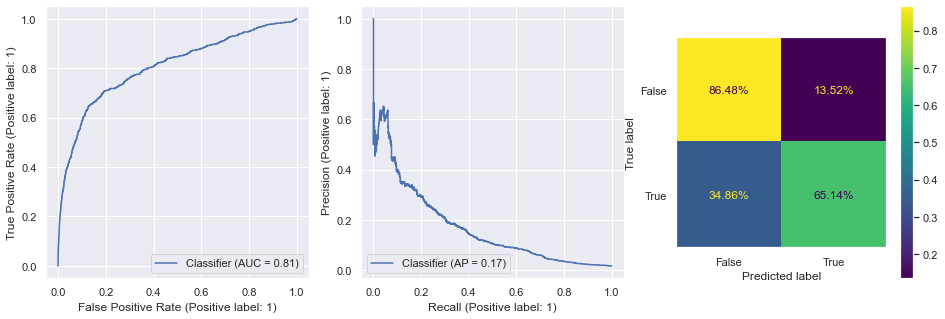

In [176]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(
    *sci.mandate(SCICols.news_data_raw).xy(
        outcome=Notebook.OUTCOME, x=SCICols.news_data_raw, dtype=float
    ),
    test_size=0.33,
    random_state=42
)

evaluate(
    LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42).fit(
        X_train, y_train
    ),
    X_test,
    y_test,
)


### Calibrating

The baseline model's pre-defined risk ratio (NEWS score $\geq 7$) yields its own precision and recall "ratio". I.e., it balances false-positives and negatives in a certain way. We can emulate this tradeoff by adjusting the class threshold in the regression model. 

In [177]:
from sklearn.metrics import precision_recall_curve, precision_score, recall_score


def get_news_target_ratio(X, y):
    y_pred = X.c_NEWS_score >= 7
    p = precision_score(y, y_pred)
    r = recall_score(y, y_pred)
    print(f"NEWS Precision={p:.5f}, Recall={r:.5f}")
    return p / r


# Get the "target" ratio of precision/recall that the NEWS threshold produces
target_ratio = get_news_target_ratio(
    *sci.mandate(SCICols.news_data_raw).xy(outcome=Notebook.OUTCOME)
)

# Train the LR model
model = LogisticRegression(class_weight="balanced", random_state=42, max_iter=1000).fit(
    X_train, y_train
)

# Get candidate thresholds from the model, and find the one that gives the ratio closest to the target
precision, recall, thresholds = precision_recall_curve(
    y_train, model.predict_proba(X_train)[:, 1]
)
closest = thresholds[
    np.abs(
        np.divide(precision, recall, out=np.ones_like(recall), where=recall != 0)
        - target_ratio
    ).argmin()
]



NEWS Precision=0.22975, Recall=0.26733


On the test set, this gives much improved F2, while the AUC remains consistent (slightly better than baseline model).

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.973642,0.235217,0.264402,0.806286,0.248957,0.257999


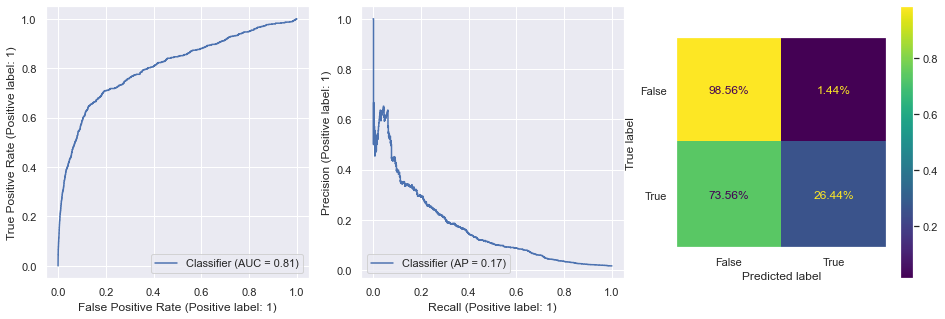

In [178]:
# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test)
y_pred = np.where(y_pred_proba[:, 1] > closest, 1, 0)

# Produce scores
evaluate_from_pred(y_test, y_pred, y_pred_proba[:, 1])


## XGBoost

Achieves best-in-class performance (nearly matched by LightGBM). Performs best on the dataset variant with mandated vitals data and one-hot encoded diagnoses with random undersampling to combat the class imbalance.

### Dataset Variants

In [180]:
scii = (
    sci.omit_redundant()
    .drop(["ReadmissionBand", "AgeBand"], axis=1)
    .omit_ae()
    .raw_news()
)

datasets_xgb = {
    "Mandated vitals, One-hot diagnoses": (
        scii.mandate_news()
        .mandate_blood()
        .augment_hsmr()
        .encode_ccs_onehot()
        .xy(outcome=Notebook.OUTCOME, dropna=True)
    ),
    "Mandated vitals, Categorical diagnoses": (
        scii.mandate_news()
        .mandate_blood()
        .impute_blood()
        .augment_hsmr()
        .xy(outcome=Notebook.OUTCOME)
    ),
    "Imputed vitals, One-hot diagnoses": (
        scii.impute_news()
        .impute_blood()
        .augment_hsmr()
        .encode_ccs_onehot()
        .xy(outcome=Notebook.OUTCOME)
    ),
    "Mandated NEWS, imputed blood, One-hot diagnoses": (
        scii.mandate_news()
        .impute_blood()
        .augment_hsmr()
        .encode_ccs_onehot()
        .xy(outcome=Notebook.OUTCOME)
    ),
    "Missing NEWS, imputed blood, One-hot diagnoses": (
        scii.augment_hsmr()
        .impute_blood()
        .encode_ccs_onehot()
        .xy(outcome=Notebook.OUTCOME)
    ),
    "Missing blood & NEWS, One-hot diagnoses": (
        scii.augment_hsmr()
        .impute_blood()
        .encode_ccs_onehot()
        .xy(outcome=Notebook.OUTCOME)
    ),
}


In [190]:
from xgboost import XGBClassifier

xgb_weight_lambda = lambda X, y: dict(scale_pos_weight=y.shape[0] / y.sum())

xgb_set_params = {
    "XGB Balanced": xgb_weight_lambda,
    "Hist XGB Balanced": xgb_weight_lambda,
}

models = {
    "Approx XGB": XGBClassifier(
        tree_method="approx", enable_categorical=True, scale_pos_weight=1
    ),
    "Approx XGB Balanced": XGBClassifier(
        tree_method="approx", enable_categorical=True,
    ),
    "Hist XGB": XGBClassifier(
        tree_method="hist", enable_categorical=True, scale_pos_weight=1
    ),
    "Hist XGB Balanced": XGBClassifier(tree_method="hist", enable_categorical=True,),
}

spotCheckDatasets(datasets=datasets_xgb, models=models, set_params=xgb_set_params)


fit_time  \
dataset                                         model                            
Imputed vitals, One-hot diagnoses               Approx XGB           34.244721   
                                                Approx XGB Balanced  33.393762   
                                                Hist XGB              5.515581   
                                                Hist XGB Balanced     5.515619   
Mandated NEWS, imputed blood, One-hot diagnoses Approx XGB           19.603910   
                                                Approx XGB Balanced  23.299996   
                                                Hist XGB              4.594377   
                                                Hist XGB Balanced     4.985664   
Mandated vitals, Categorical diagnoses          Approx XGB           10.717001   
                                                Approx XGB Balanced  10.800445   
                                                Hist XGB              1.729041   
                                                Hist XGB Balanced     1.785557   
Mandated vitals, One-hot diagnoses              Approx XGB           10.959021   
                                                Approx XGB Balanced  10.903010   
                                                Hist XGB              1.836753   
                                                Hist XGB Balanced     1.837751   
Missing NEWS, imputed blood, One-hot diagnoses  Approx XGB           41.996340   
                                                Approx XGB Balanced  33.177353   
                                                Hist XGB              7.086470   
                                                Hist XGB Balanced     5.646563   
Missing blood & NEWS, One-hot diagnoses         Approx XGB           33.257991   
                                                Approx XGB Balanced  33.032081   
                                                Hist XGB              7.419492   
                                                Hist XGB Balanced     5.597372   

                                                                     score_time  \
dataset                                         model                             
Imputed vitals, One-hot diagnoses               Approx XGB             1.188252   
                                                Approx XGB Balanced    1.168222   
                                                Hist XGB               1.306505   
                                                Hist XGB Balanced      1.286379   
Mandated NEWS, imputed blood, One-hot diagnoses Approx XGB             0.694487   
                                                Approx XGB Balanced    0.964088   
                                                Hist XGB               1.060165   
                                                Hist XGB Balanced      1.037558   
Mandated vitals, Categorical diagnoses          Approx XGB             0.398933   
                                                Approx XGB Balanced    0.409904   
                                                Hist XGB               0.409903   
                                                Hist XGB Balanced      0.404917   
Mandated vitals, One-hot diagnoses              Approx XGB             0.411235   
                                                Approx XGB Balanced    0.383811   
                                                Hist XGB               0.410901   
                                                Hist XGB Balanced      0.417217   
Missing NEWS, imputed blood, One-hot diagnoses  Approx XGB             1.244966   
                                                Approx XGB Balanced    1.252999   
                                                Hist XGB               1.361057   
                                                Hist XGB Balanced      1.326452   
Missing blood & NEWS, One-hot diagnoses         Approx XGB             1.218083   
                            

### Resampling

In [192]:
X, y = datasets_xgb["Mandated NEWS, imputed blood, One-hot diagnoses"]
categorical_cols_idx = X.describe_categories()[0]
X = X.ordinal_encode_categories().fillna(-1)
scale_pos_weight = y.shape[0] / y.sum()
spotCheckCV(
    {
        "XGB": XGBClassifier(
            tree_method="hist",
            enable_categorical=True,
            scale_pos_weight=scale_pos_weight,
        ),
        **with_sampling_strategies(
            XGBClassifier(
                tree_method="hist",
                enable_categorical=True,
                scale_pos_weight=scale_pos_weight,
            ),
            "XGB",
            categorical_cols_idx,
        ),
    },
    X,
    y,
)



,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
XGB,1.280241,0.241022,0.979935,0.395952,0.377433,0.896903,0.384444,0.379790
XGB_OverUnder,7.152201,0.215424,0.950734,0.202623,0.658484,0.918907,0.309465,0.453285
XGB_SMOTE,15.870879,0.207778,0.972851,0.294024,0.439046,0.888170,0.352082,0.399523
XGB_SMOTE-Tomek,182.291634,0.236368,0.973175,0.297375,0.437759,0.883034,0.354057,0.399895
XGB_Undersampling,0.579449,0.215756,0.956912,0.229994,0.658559,0.923712,0.340065,0.478248


### Hyperparameters

In [424]:
param_grid = {
    "XGB__max_depth": np.arange(10, 25, 1),
    "XGB__learning_rate": [0.01, 0.025, 0.05, 0.085, 0.1, 0.15, 0.2, 0.25, 0.3],
    "XGB__subsample": np.arange(0.3, 1.0, 0.05),
    "XGB__colsample_bytree": np.arange(0.1, 1.0, 0.05),
    "XGB__colsample_bylevel": np.arange(0.6, 1.0, 0.05),
    "XGB__n_estimators": np.arange(50, 250, 10),
    "XGB__scale_pos_weight": np.arange(1, 60, 2),
}


In [420]:
from sklearn.model_selection import RandomizedSearchCV

model = ImbPipeline(
    steps=[
        ("undersampling", RandomUnderSampler(sampling_strategy=0.1)),
        (
            "XGB",
            XGBClassifier(
                tree_method="approx",
                enable_categorical=True,
                scale_pos_weight=(y_train.shape[0] / (2 * y_train.sum())),
            ),
        ),
    ]
)

xgb_tuned = RandomizedSearchCV(
    model, param_distributions=param_grid, scoring=f2_score, n_iter=100, verbose=1
)



### Evaluation

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.968061,0.294849,0.645914,0.936531,0.404878,0.521684


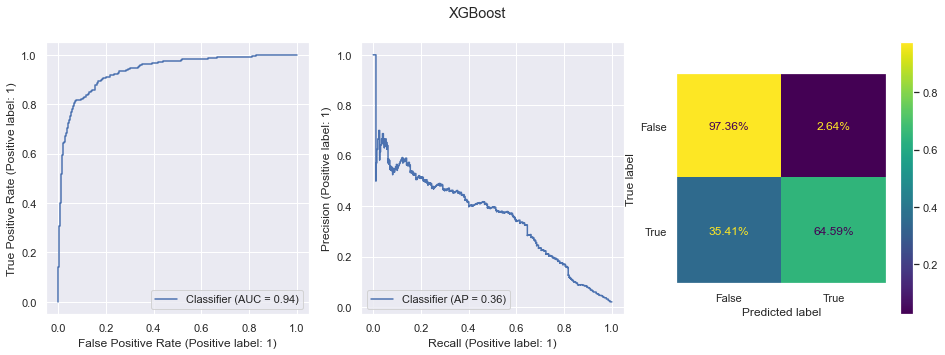

In [181]:
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

X, y = (
    sci.omit_redundant()
    .drop(["ReadmissionBand", "AgeBand"], axis=1)
    .omit_ae()
    .raw_news()
    .mandate_news()
    .mandate_blood()
    .augment_hsmr()
    .encode_ccs_onehot()
    .xy(
        outcome=Notebook.OUTCOME, dropna=False, ordinal_encoding=True
    )  # Use ordinal encoding because of bug in XGB that prevents use of SHAP when pd.categorical is involved
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.33, random_state=42
)

model = ImbPipeline(
    steps=[
        ("undersampling", RandomUnderSampler(sampling_strategy=0.1)),
        (
            "XGB",
            XGBClassifier(
                tree_method="approx",
                enable_categorical=True,
                subsample=0.85,
                scale_pos_weight=31,
                n_estimators=140,
                max_depth=13,
                learning_rate=0.05,
                colsample_bytree=0.7,
                colsample_bylevel=0.9,
            ),
        ),
    ]
).fit(X_train, y_train)

evaluate(model, X_test, y_test, "XGBoost")


#### Recalibrating

We can further minimise false-negatives (at the expense of FPR) by altering the decision threshold manually. Below, we set it such that training recall/sensitivity approaches 0.95.

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.698737,0.05029,0.945525,0.936531,0.0955,0.207338


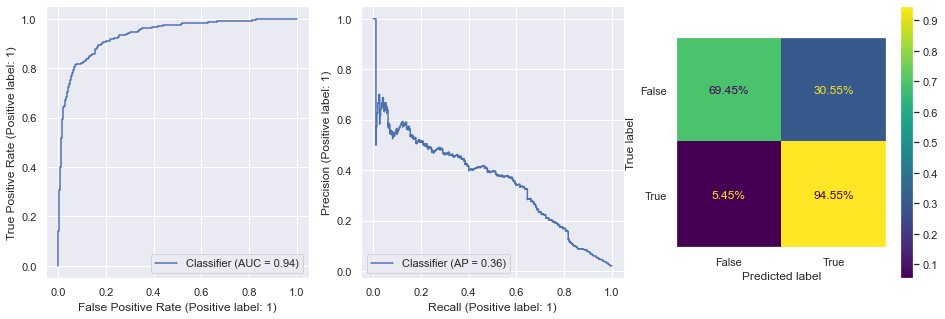

In [182]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(
    y_train, model.predict_proba(X_train)[:, 1]
)

closest = thresholds[np.abs(recall - 0.95).argmin()]

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test)
y_pred = np.where(y_pred_proba[:, 1] > 1 - closest, 1, 0)

# Produce scores
evaluate_from_pred(y_test, y_pred, y_pred_proba[:, 1])


### Explanations

<AxesSubplot:>

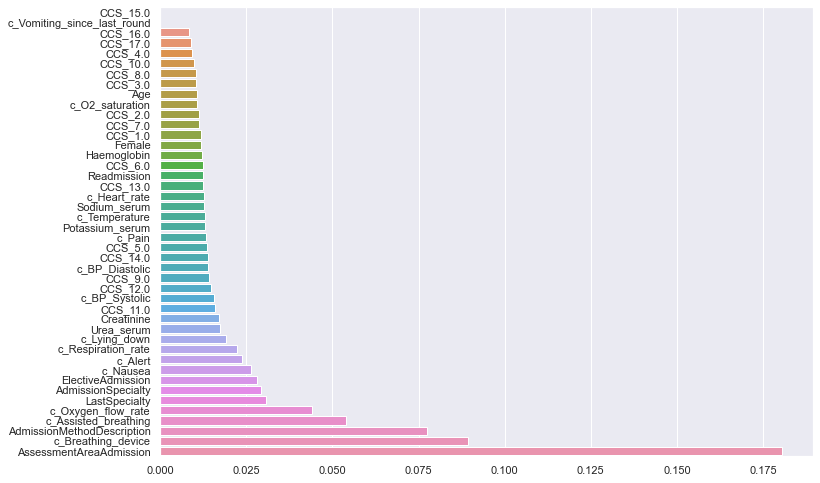

In [183]:
sorted_idx = model["XGB"].feature_importances_.argsort()
sns.barplot(
    x=model["XGB"].feature_importances_[sorted_idx], y=X_train.columns[sorted_idx]
)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


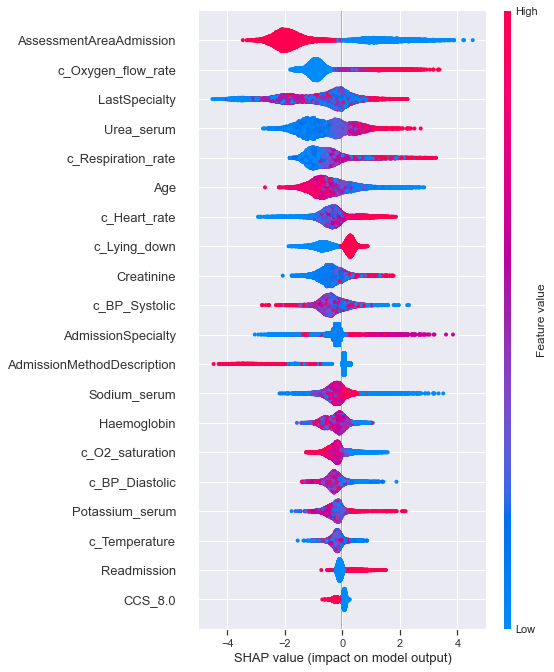

In [199]:
import shap

explainer = shap.TreeExplainer(model["XGB"])
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)


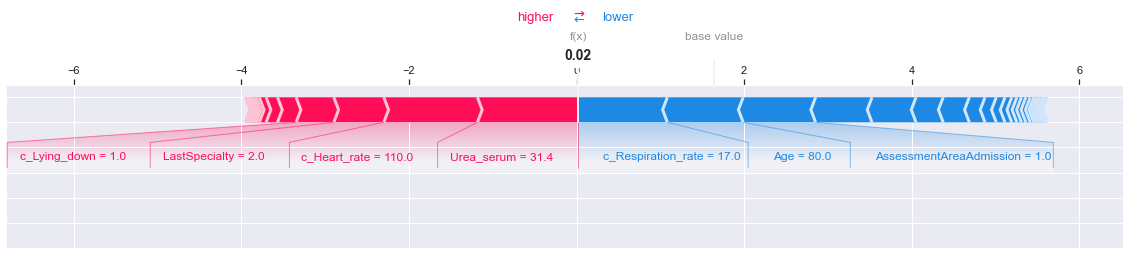

In [200]:
positive_class_idx = np.argmax(model.predict(X_test) == 1)
shap.force_plot(
    explainer.expected_value,
    shap_values[positive_class_idx, :],
    X_test.iloc[positive_class_idx],
    feature_names=X_test.columns,
    matplotlib=True,
)



## Random Forest

### Dataset Variants

In [185]:
scii = (
    sci.omit_redundant()
    .drop(["ReadmissionBand", "AgeBand"], axis=1)
    .omit_ae()
    .raw_news()
)

datasets_rf = {
    "Mandated vitals, One-hot diagnoses": (
        scii.mandate_news()
        .mandate_blood()
        .augment_hsmr()
        .encode_ccs_onehot()
        .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, dropna=True)
    ),
    "Mandated vitals, Categorical diagnoses (main only)": (
        scii.mandate_news()
        .mandate_blood()
        .augment_hsmr()
        .drop(SCICols.diagnoses[1:], axis=1)
        .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, dropna=True)
    ),
    "Mandated vitals, Categorical diagnoses (with missing)": (
        scii.mandate_news()
        .mandate_blood()
        .augment_hsmr()
        .drop(SCICols.diagnoses[1:], axis=1)
        .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, fillna=True)
    ),
    "Imputed vitals": (
        scii.impute_news()
        .impute_blood()
        .augment_hsmr()
        .encode_ccs_onehot()
        .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, dropna=True)
    ),
    "Missing NEWS, imputed blood": (
        scii.augment_hsmr()
        .impute_blood()
        .encode_ccs_onehot()
        .mandate_diagnoses()
        .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, fillna=True)
    ),
    "Missing vitals": (
        scii.augment_hsmr()
        .impute_blood()
        .encode_ccs_onehot()
        .mandate_diagnoses()
        .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, fillna=True)
    ),
}


In [24]:
from sklearn.ensemble import RandomForestClassifier

models = {
    "Random Forest": RandomForestClassifier(),
    "Random Forest (balanced)": RandomForestClassifier(
        class_weight="balanced_subsample"
    ),
}


In [25]:
spotCheckDatasets(datasets=datasets_rf, models=models)


fit_time  \
dataset                                            model                                 
Imputed vitals                                     Random Forest             28.479960   
                                                   Random Forest (balanced)  24.692130   
Mandated vitals, Categorical diagnoses (main only) Random Forest              5.459934   
                                                   Random Forest (balanced)   4.866982   
Mandated vitals, Categorical diagnoses (with mi... Random Forest              5.604026   
                                                   Random Forest (balanced)   5.040210   
Mandated vitals, One-hot diagnoses                 Random Forest              6.422156   
                                                   Random Forest (balanced)   5.785192   
Missing NEWS, imputed blood                        Random Forest             27.393974   
                                                   Random Forest (balanced)  25.239340   
Missing vitals                                     Random Forest             27.502067   
                                                   Random Forest (balanced)  25.129190   

                                                                             score_time  \
dataset                                            model                                  
Imputed vitals                                     Random Forest               2.870660   
                                                   Random Forest (balanced)    2.741665   
Mandated vitals, Categorical diagnoses (main only) Random Forest               0.563160   
                                                   Random Forest (balanced)    0.497003   
Mandated vitals, Categorical diagnoses (with mi... Random Forest               0.538891   
                                                   Random Forest (balanced)    0.522271   
Mandated vitals, One-hot diagnoses                 Random Forest               0.678186   
                                                   Random Forest (balanced)    0.574462   
Missing NEWS, imputed blood                        Random Forest               2.833780   
                                                   Random Forest (balanced)    2.738355   
Missing vitals                                     Random Forest               2.772282   
                                                   Random Forest (balanced)    2.736690   

                                                                             test_Accuracy  \
dataset                                            model                                     
Imputed vitals                                     Random Forest                  0.984049   
                                                   Random Forest (balanced)       0.983706   
Mandated vitals, Categorical diagnoses (main only) Random Forest                  0.983580   
                                                   Random Forest (balanced)       0.983227   
Mandated vitals, Categorical diagnoses (with mi... Random Forest                  0.983564   
                                                   Random Forest (balanced)       0.983283   
Mandated vitals, One-hot diagnoses                 Random Forest                  0.983448   
                                                   Random Forest (balanced)       0.983315   
Missing NEWS, imputed blood                        Random Forest                  0.984133   
                                                   Random Forest (balanced)       0.983791   
Missing vitals                                     Random Forest                  0.984061   
                                                   Random Forest (balanced)       0.983784   

                                                                             test_Precision  \
dataset                                            model                                      
Imputed vitals                     

### Resampling

In [26]:
dataset = datasets_rf["Mandated vitals, One-hot diagnoses"]
categorical_cols_idx = dataset[0].describe_categories()[0]
spotCheckCV(
    {
        "Random Forest": RandomForestClassifier(),
        **with_sampling_strategies(
            RandomForestClassifier(), "Random Forest", categorical_cols_idx
        ),
    },
    *dataset
)



,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
Random Forest,5.428974,0.581113,0.983337,0.685185,0.028758,0.903888,0.054756,0.035498
Random Forest_OverUnder,3.102823,0.593412,0.977326,0.356988,0.420915,0.922276,0.385579,0.405797
Random Forest_SMOTE,16.535836,0.564158,0.982983,0.499851,0.087582,0.914452,0.146458,0.104305
Random Forest_SMOTE-Tomek,178.128726,0.608869,0.983006,0.508790,0.091503,0.914805,0.154068,0.109225
Random Forest_Undersampling,1.037891,0.565487,0.978696,0.379733,0.389542,0.925640,0.381778,0.385662


### Evaluation

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.978236,0.380328,0.460317,0.910988,0.416517,0.441736


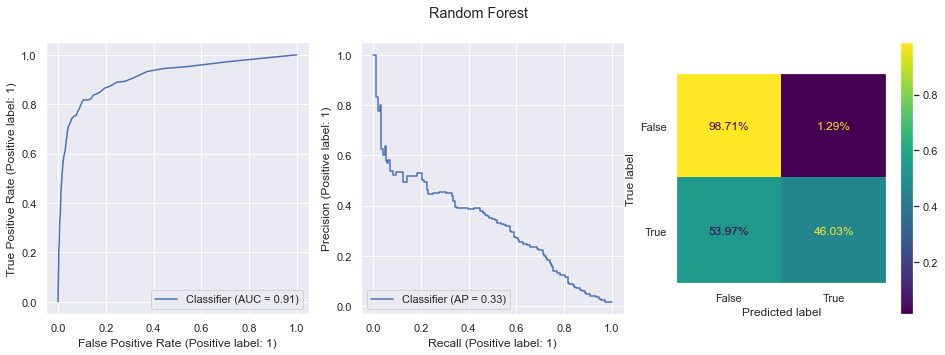

In [186]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

X, y = (
    sci.omit_redundant()
    .drop(["ReadmissionBand", "AgeBand"], axis=1)
    .omit_ae()
    .raw_news()
    .mandate_news()
    .mandate_blood()
    .augment_hsmr()
    .encode_ccs_onehot()
    .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, dropna=True)
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.33, random_state=42
)

model = ImbPipeline(
    steps=[
        ("undersampling", RandomUnderSampler(sampling_strategy=0.1)),
        ("randomforest", RandomForestClassifier()),
    ]
).fit(X_train, y_train)

evaluate(model, X_test, y_test, "Random Forest")


### Explanations

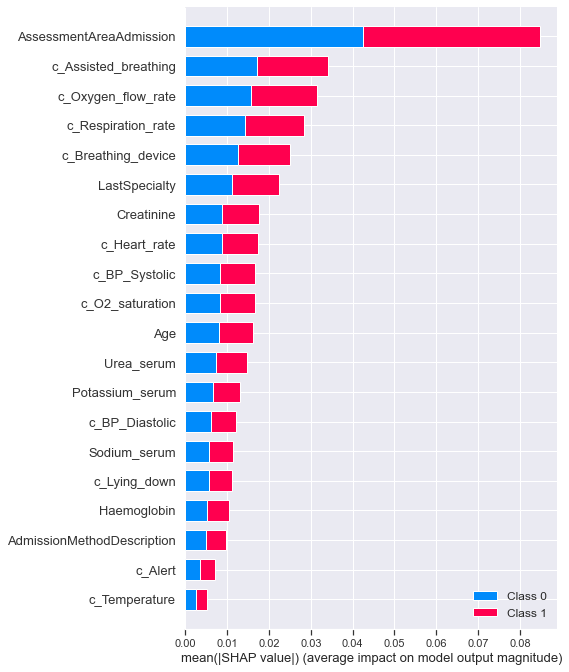

In [28]:
import shap

explainer = shap.TreeExplainer(model["randomforest"])
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)


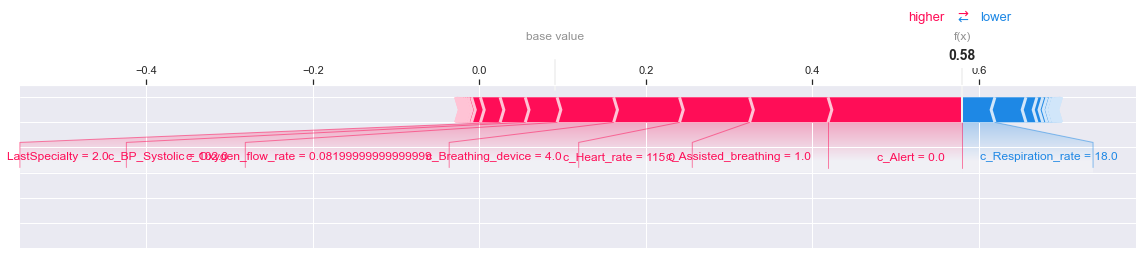

In [29]:
positive_class_idx = np.argmax(model.predict(X_test) == 1)
shap.force_plot(
    explainer.expected_value[1],
    shap_values[1][positive_class_idx, :],
    X_test.iloc[positive_class_idx],
    feature_names=X_test.columns,
    matplotlib=True,
)



## Isolation Forest

Unlike other models tested, this is a one-class model that detects outliers instead of predicting outcomes. We test the hypothesis that "abnormal" values associated with the tracked outcome will be outliers compared to the normal ranges.

In [187]:
class IsolationForestWrapper(IsolationForest):
    """ Wraps the scikit-learn Isolation Forest model to adapt it to our test harness. This is because the original gives non-standard outputs when predicting """

    def __init__(
        self,
        *,
        n_estimators=100,
        max_samples="auto",
        contamination="auto",
        max_features=1.0,
        bootstrap=False,
        n_jobs=None,
        random_state=None,
        verbose=0,
        warm_start=False,
    ):
        super().__init__(
            bootstrap=bootstrap,
            n_estimators=n_estimators,
            max_samples=max_samples,
            max_features=max_features,
            warm_start=warm_start,
            n_jobs=n_jobs,
            random_state=random_state,
            verbose=verbose,
            contamination=contamination,
        )

    def predict(self, X):
        return np.fromiter(map({-1: 0, 1: 1}.get, super().predict(X)), dtype=int)

    def decision_function(self, X):
        return -super().decision_function(X)


### Dataset Variants

In [89]:
from sklearn.ensemble import IsolationForest

models = {
    "Isolation Forest": IsolationForestWrapper(),
    "Isolation Forest (contamination)": IsolationForestWrapper(),
}
isolation_forest_set_params = {
    "Isolation Forest (contamination)": lambda X, y: dict(
        contamination=(y.sum()) / y.shape[0]
    )
}


In [90]:
spotCheckDatasets(
    datasets=datasets_rf, models=models, set_params=isolation_forest_set_params
)


fit_time  \
dataset                                            model                                         
Imputed vitals                                     Isolation Forest                   7.279862   
                                                   Isolation Forest (contamination)  18.850247   
Mandated vitals, Categorical diagnoses (main only) Isolation Forest                   1.523923   
                                                   Isolation Forest (contamination)   3.872974   
Mandated vitals, Categorical diagnoses (with mi... Isolation Forest                   1.598391   
                                                   Isolation Forest (contamination)   3.934144   
Mandated vitals, One-hot diagnoses                 Isolation Forest                   2.226046   
                                                   Isolation Forest (contamination)   5.093376   
Missing NEWS, imputed blood                        Isolation Forest                   7.159184   
                                                   Isolation Forest (contamination)  19.017467   
Missing vitals                                     Isolation Forest                   7.152205   
                                                   Isolation Forest (contamination)  18.853240   

                                                                                     score_time  \
dataset                                            model                                          
Imputed vitals                                     Isolation Forest                   11.707354   
                                                   Isolation Forest (contamination)   11.477967   
Mandated vitals, Categorical diagnoses (main only) Isolation Forest                    2.432494   
                                                   Isolation Forest (contamination)    2.400912   
Mandated vitals, Categorical diagnoses (with mi... Isolation Forest                    2.452441   
                                                   Isolation Forest (contamination)    2.452108   
Mandated vitals, One-hot diagnoses                 Isolation Forest                    3.095720   
                                                   Isolation Forest (contamination)    2.852371   
Missing NEWS, imputed blood                        Isolation Forest                   11.754561   
                                                   Isolation Forest (contamination)   12.001567   
Missing vitals                                     Isolation Forest                   11.558417   
                                                   Isolation Forest (contamination)   11.587009   

                                                                                     test_Accuracy  \
dataset                                            model                                             
Imputed vitals                                     Isolation Forest                       0.903128   
                                                   Isolation Forest (contamination)       0.969204   
Mandated vitals, Categorical diagnoses (main only) Isolation Forest                       0.914431   
                                                   Isolation Forest (contamination)       0.969348   
Mandated vitals, Categorical diagnoses (with mi... Isolation Forest                       0.922247   
                                                   Isolation Forest (contamination)       0.969482   
Mandated vitals, One-hot diagnoses                 Isolation Forest                       0.886697   
                                                   Isolation Forest (contamination)       0.968310   
Missing NEWS, imputed blood                        Isolation Forest                       0.837899   
                                                   Isolation Forest (contamination)       0.965730   
Missing vitals                                     Isolation Forest                       0.838891   


### Evaluation

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.904053,0.262425,0.517647,0.847107,0.348285,0.433355


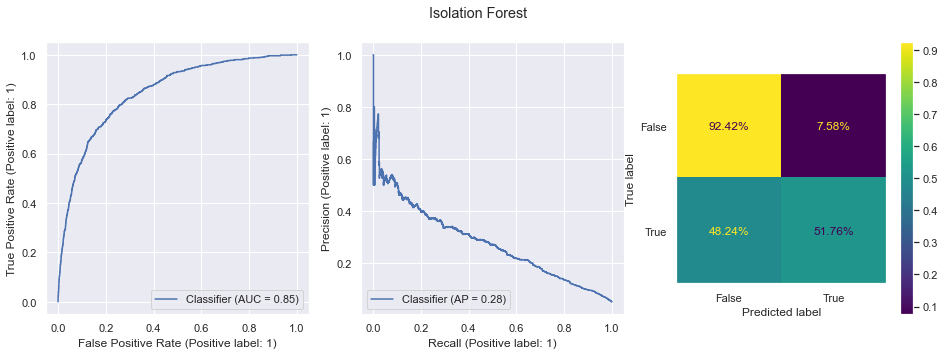

In [188]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

X, y = datasets_rf["Mandated vitals, Categorical diagnoses (main only)"]
X_train, X_test, y_train, y_test = train_test_split_oneclass(
    X, y, label=y, test_size=0.33, random_state=42
)
X_train, X_test = X_train.to_numpy(), X_test.to_numpy()

model = IsolationForestWrapper().fit(X_train)
evaluate(model, X_test, y_test, "Isolation Forest")


,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.788489,0.156319,0.743791,0.847107,0.258343,0.424627


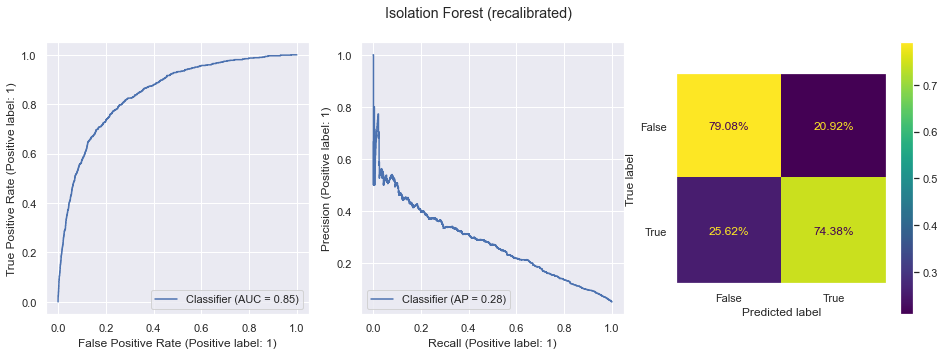

In [189]:
# Create predictions on the test set, using this new threshold
y_pred_proba = model.decision_function(X_test)
y_pred = np.where(y_pred_proba > -0.05, 1, 0)

# Produce scores
evaluate_from_pred(y_test, y_pred, y_pred_proba, "Isolation Forest (recalibrated)")


### Explanations

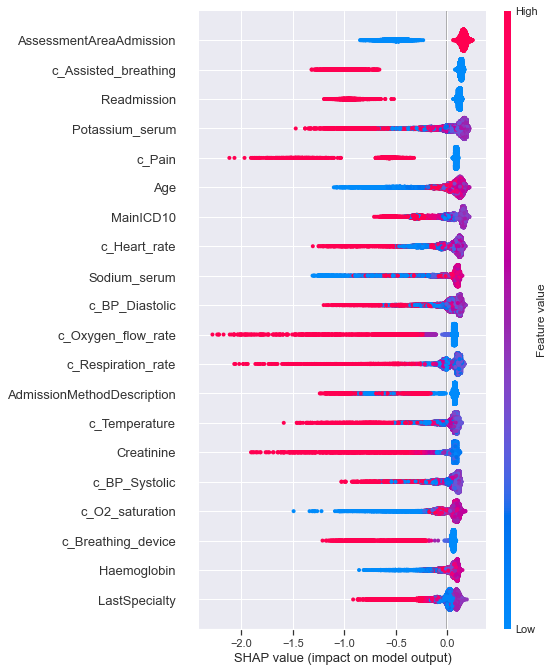

In [34]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)


X has feature names, but IsolationForest was fitted without feature names


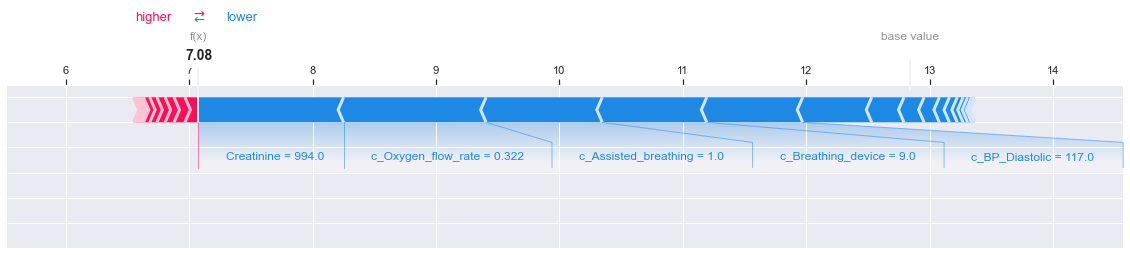

In [35]:
positive_class_idx = np.argmax(model.predict(X_test) == -1)
shap.force_plot(
    explainer.expected_value,
    shap_values[positive_class_idx, :],
    X_test.iloc[positive_class_idx],
    feature_names=X_test.columns,
    matplotlib=True,
)



## LightGBM

### Dataset Variants

In [111]:
from lightgbm import LGBMClassifier

lightgbm_set_params = {
    "LightGBM Weighted": lambda X, y: dict(scale_pos_weight=y.shape[0] / y.sum())
}

spotCheckDatasets(
    datasets=datasets_xgb,
    models={
        "LightGBM": LGBMClassifier(metric=["l2", "auc"]),
        "LightGBM Balanced": LGBMClassifier(metric=["l2", "auc"], is_unbalance=True),
        "LightGBM Weighted": LGBMClassifier(metric=["l2", "auc"]),
    },
    set_params=lightgbm_set_params,
)



fit_time  \
dataset                                        model                         
Imputed vitals, One-hot diagnoses              LightGBM           2.877636   
                                               LightGBM Balanced  3.123645   
                                               LightGBM Weighted  3.071118   
Mandated vitals, Categorical diagnoses         LightGBM           0.923529   
                                               LightGBM Balanced  0.976720   
                                               LightGBM Weighted  1.036560   
Mandated vitals, One-hot diagnoses             LightGBM           0.886628   
                                               LightGBM Balanced  0.935501   
                                               LightGBM Weighted  0.946467   
Missing NEWS, imputed blood, One-hot diagnoses LightGBM           3.095719   
                                               LightGBM Balanced  3.264600   
                                               LightGBM Weighted  3.279893   
Missing blood & NEWS, One-hot diagnoses        LightGBM           3.134948   
                                               LightGBM Balanced  3.264269   
                                               LightGBM Weighted  3.299840   

                                                                  score_time  \
dataset                                        model                           
Imputed vitals, One-hot diagnoses              LightGBM             1.914213   
                                               LightGBM Balanced    2.263945   
                                               LightGBM Weighted    2.224385   
Mandated vitals, Categorical diagnoses         LightGBM             0.560501   
                                               LightGBM Balanced    0.707109   
                                               LightGBM Weighted    0.684171   
Mandated vitals, One-hot diagnoses             LightGBM             0.552855   
                                               LightGBM Balanced    0.559166   
                                               LightGBM Weighted    0.645939   
Missing NEWS, imputed blood, One-hot diagnoses LightGBM             2.033229   
                                               LightGBM Balanced    2.598053   
                                               LightGBM Weighted    2.538876   
Missing blood & NEWS, One-hot diagnoses        LightGBM             2.069132   
                                               LightGBM Balanced    2.565139   
                                               LightGBM Weighted    2.490340   

                                                                  test_Accuracy  \
dataset                                        model                              
Imputed vitals, One-hot diagnoses              LightGBM                0.983668   
                                               LightGBM Balanced       0.904293   
                                               LightGBM Weighted       0.901243   
Mandated vitals, Categorical diagnoses         LightGBM                0.982441   
                                               LightGBM Balanced       0.964212   
                                               LightGBM Weighted       0.964017   
Mandated vitals, One-hot diagnoses             LightGBM                0.982254   
                                               LightGBM Balanced       0.962077   
                                               LightGBM Weighted       0.963602   
Missing NEWS, imputed blood, One-hot diagnoses LightGBM                0.983879   
                                               LightGBM Balanced       0.904386   
                                               LightGBM Weighted       0.904369   
Missing blood & NEWS, One-hot diagnoses        LightGBM                0.983879   
                                               LightGBM Balanced       0.904386   
                                               Lig

### Resampling

In [120]:
X, y = datasets_xgb["Mandated vitals, One-hot diagnoses"]
categorical_cols_idx = X.describe_categories()[0]
X = X.ordinal_encode_categories()
result = spotCheckCV(
    {
        "LightGBM": LGBMClassifier(
            metric=["l2", "auc"], scale_pos_weight=y.shape[0] / y.sum()
        ),
        **with_sampling_strategies(
            LGBMClassifier(metric=["l2", "auc"], scale_pos_weight=y.shape[0] / y.sum()),
            "LightGBM",
            categorical_cols_idx,
        ),
    },
    X,
    y,
)

display(result)


,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
LightGBM,0.884301,0.576791,0.959647,0.230466,0.584314,0.906326,0.329237,0.444946
LightGBM_OverUnder,2.648249,0.538892,0.917039,0.141010,0.754248,0.910544,0.237088,0.401771
LightGBM_SMOTE,6.433458,0.485369,0.951205,0.207203,0.661438,0.918630,0.314806,0.458349
LightGBM_SMOTE-Tomek,166.768970,0.531246,0.950519,0.204260,0.665359,0.919373,0.312320,0.457903
LightGBM_Undersampling,0.353054,0.557509,0.924685,0.154568,0.763399,0.929111,0.256519,0.425319


In [ ]:
param_grid = {
    "learning_rate": [0.01, 0.025, 0.05, 0.085, 0.1, 0.15, 0.2, 0.25, 0.3],
    "boosting_type": ["gbdt", "dart", "goss"],
    "sub_feature": np.arange(0, 1, 0.05),
    "num_leaves": np.arange(20, 300, 20),
    "min_data": np.arange(10, 100, 10),
    "max_depth": np.arange(5, 200, 20),
    "scale_pos_weight": np.arange(1, 60, 2),
    "colsample_bytree": np.arange(0.1, 1.0, 0.05),
    "subsample": np.arange(0.3, 1.0, 0.05),
}


### Evaluation

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.95962,0.259972,0.744094,0.932925,0.385321,0.542169


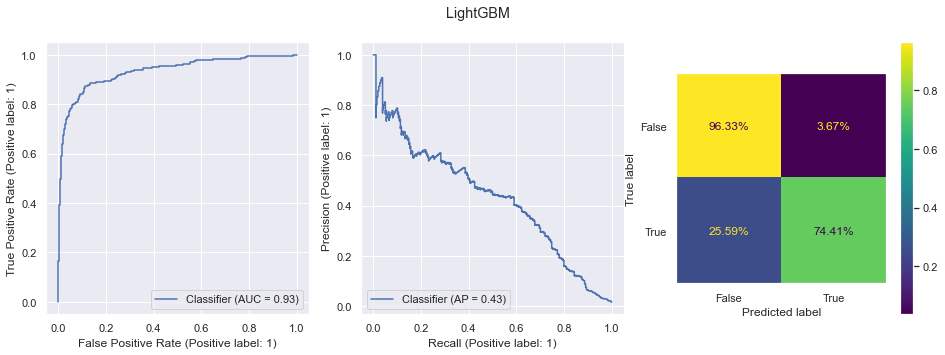

In [190]:
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    *sci.omit_redundant()
    .drop(["ReadmissionBand", "AgeBand"], axis=1)
    .omit_ae()
    .raw_news()
    .mandate_news()
    .mandate_blood()
    .augment_hsmr()
    .encode_ccs_onehot()
    .xy(outcome=Notebook.OUTCOME, dropna=True),
    test_size=0.33,
    random_state=42
)

model = ImbPipeline(
    steps=[
        ("undersampling", RandomUnderSampler(sampling_strategy=0.1)),
        ("lightgbm", LGBMClassifier(metric=["l2", "auc"], is_unbalance=True)),
    ]
).fit(X_train, y_train)

evaluate(model, X_test, y_test, "LightGBM")


#### Recalibrating
We recalibrate to further minimise false-negatives. Here we set it such that training recall/sensitivity is 0.95.

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.850733,0.092784,0.885827,0.932925,0.167973,0.32694


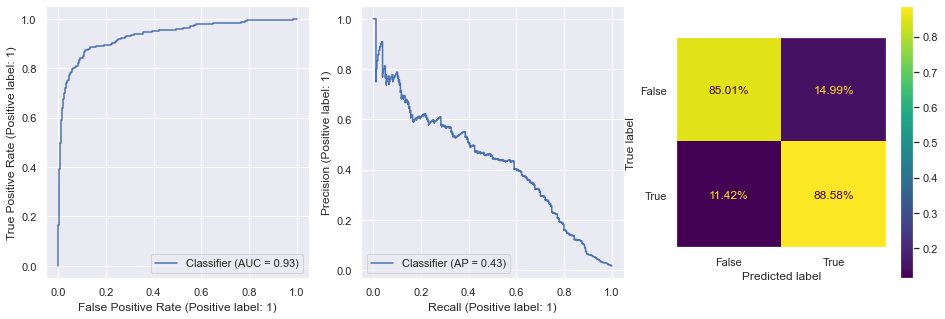

In [191]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(
    y_train, model.predict_proba(X_train)[:, 1]
)

closest = thresholds[np.abs(recall - 0.95).argmin()]

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test)
y_pred = np.where(y_pred_proba[:, 1] > 1 - closest, 1, 0)

# Produce scores
evaluate_from_pred(y_test, y_pred, y_pred_proba[:, 1])


### Explanations

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

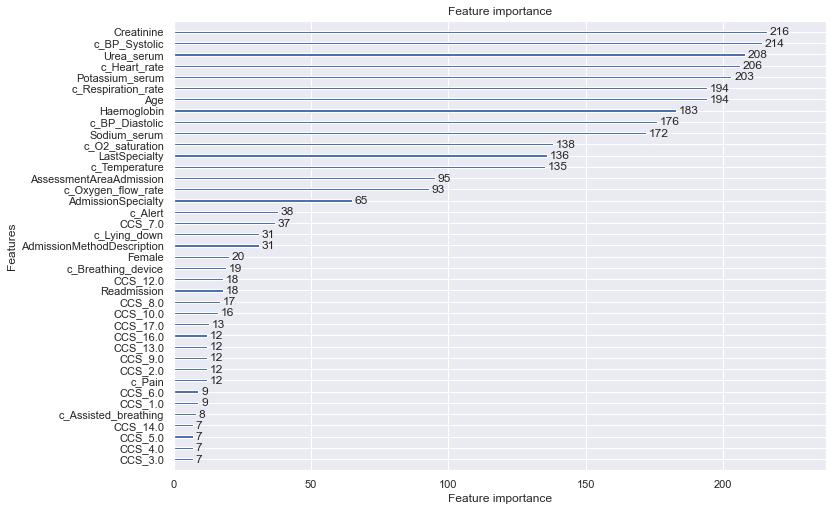

In [192]:
import lightgbm as lgb

lgb.plot_importance(model["lightgbm"])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


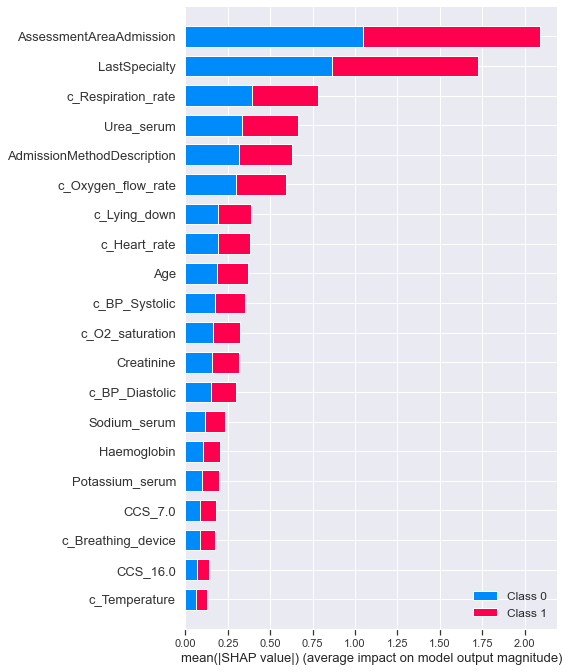

In [41]:
import shap

explainer = shap.TreeExplainer(model["lightgbm"])
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)


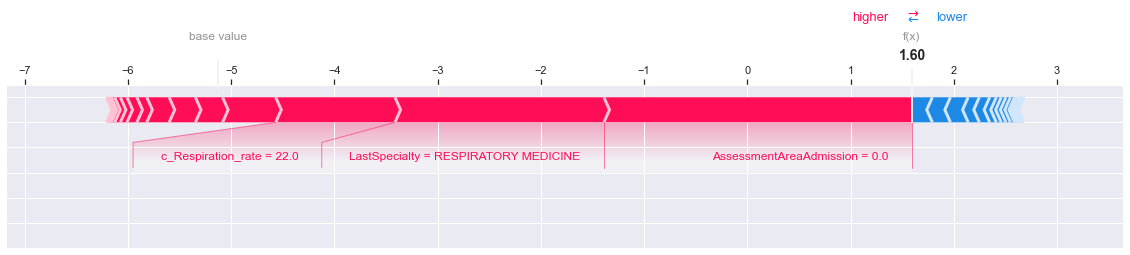

In [42]:
positive_class_idx = np.argmax(model.predict(X_test) == 1)
shap.force_plot(
    explainer.expected_value[1],
    shap_values[1][positive_class_idx, :],
    X_test.iloc[positive_class_idx],
    feature_names=X_test.columns,
    matplotlib=True,
    contribution_threshold=0.12,
)



## TabNet

Deep-learning model for outcome prediction.

In [8]:
from sklearn.metrics import fbeta_score
from pytorch_tabnet.metrics import Metric


class F2TabNet(Metric):
    def __init__(self):
        self._name = "F2"
        self._maximize = True

    def __call__(self, y_true, y_score):
        y_pred = np.argmax(y_score, axis=1)
        return fbeta_score(y_true, y_pred, beta=2)


In [194]:
X, y = (
    sci.omit_redundant()
    .drop(["ReadmissionBand", "AgeBand"], axis=1)
    .omit_ae()
    .raw_news()
    .mandate_news()
    .mandate_blood()
    .augment_hsmr()
    .encode_ccs_onehot()
    .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, dropna=True)
)

categorical_cols_idx, categorical_cols_dims = X.describe_categories()

X_train, X_test, y_train, y_test = train_test_split(
    X.to_numpy(), y.to_numpy(), stratify=y, test_size=0.25, random_state=42
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, stratify=y_train, test_size=0.33, random_state=42
)


In [143]:
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

tabnet_params = dict(
    n_a=24,
    n_d=24,
    cat_idxs=categorical_cols_idx,
    cat_dims=categorical_cols_dims,
    cat_emb_dim=1,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.1),
    scheduler_params=dict(step_size=50, gamma=0.7),
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type="entmax",
    verbose=True,
)

tabnet_model = TabNetClassifier(**tabnet_params)

tabnet_model.fit(
    X_train=X_train,
    y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid),],
    eval_name=["train", "valid"],
    eval_metric=[F2TabNet],
    max_epochs=300,
    patience=50,
    batch_size=512,
    virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
)


Device used : cpu
epoch 0  | loss: 0.48407 | train_F2: 0.11985 | valid_F2: 0.07765 |  0:00:05s
epoch 1  | loss: 0.27566 | train_F2: 0.1357  | valid_F2: 0.13503 |  0:00:10s
epoch 2  | loss: 0.225   | train_F2: 0.16548 | valid_F2: 0.16135 |  0:00:15s
epoch 3  | loss: 0.20209 | train_F2: 0.32051 | valid_F2: 0.31388 |  0:00:22s
epoch 4  | loss: 0.17165 | train_F2: 0.45437 | valid_F2: 0.39117 |  0:00:27s
epoch 5  | loss: 0.16302 | train_F2: 0.56153 | valid_F2: 0.44248 |  0:00:32s
epoch 6  | loss: 0.14532 | train_F2: 0.65185 | valid_F2: 0.44107 |  0:00:38s
epoch 7  | loss: 0.1245  | train_F2: 0.67308 | valid_F2: 0.41481 |  0:00:43s
epoch 8  | loss: 0.10716 | train_F2: 0.66939 | valid_F2: 0.43829 |  0:00:48s
epoch 9  | loss: 0.09754 | train_F2: 0.70692 | valid_F2: 0.46091 |  0:00:54s
epoch 10 | loss: 0.08149 | train_F2: 0.7085  | valid_F2: 0.43622 |  0:01:00s
epoch 11 | loss: 0.08936 | train_F2: 0.73558 | valid_F2: 0.44862 |  0:01:07s
epoch 12 | loss: 0.0785  | train_F2: 0.68141 | valid_F2: 0

### Evaluation

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.965438,0.261905,0.575916,0.860058,0.360065,0.464527


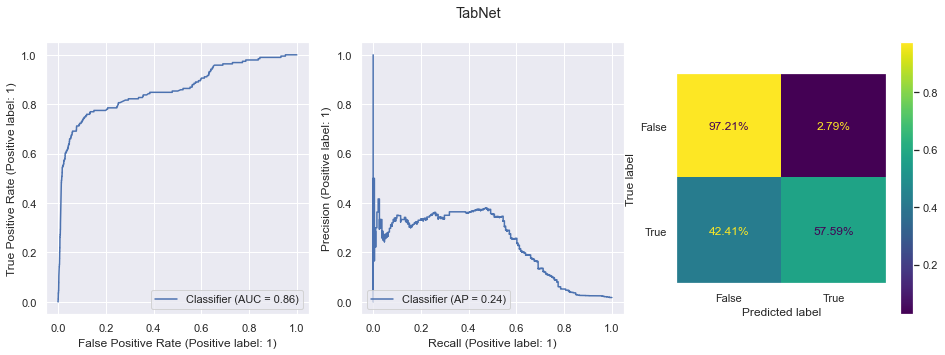

In [195]:
evaluate(tabnet_model, X_test, y_test, "TabNet")



#### Recalibrating

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.759834,0.053079,0.78534,0.860058,0.099437,0.208914


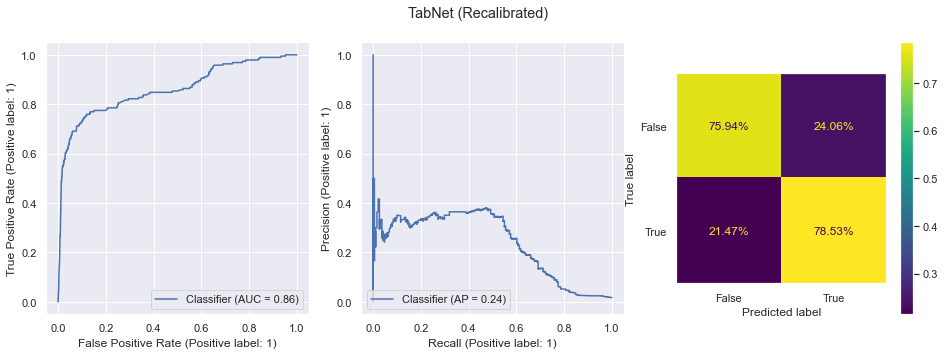

In [213]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(
    y_train, tabnet_model.predict_proba(X_train)[:, 1]
)

closest = thresholds[np.abs(recall - 0.8).argmin()]

# Create predictions on the test set, using this new threshold
y_pred_proba = tabnet_model.predict_proba(X_test)
y_pred = np.where(y_pred_proba[:, 1] > 25e-5, 1, 0)

# Produce scores
evaluate_from_pred(
    pd.Series(y_test), y_pred, y_pred_proba[:, 1], "TabNet (Recalibrated)"
)



### Explanations

<AxesSubplot:>

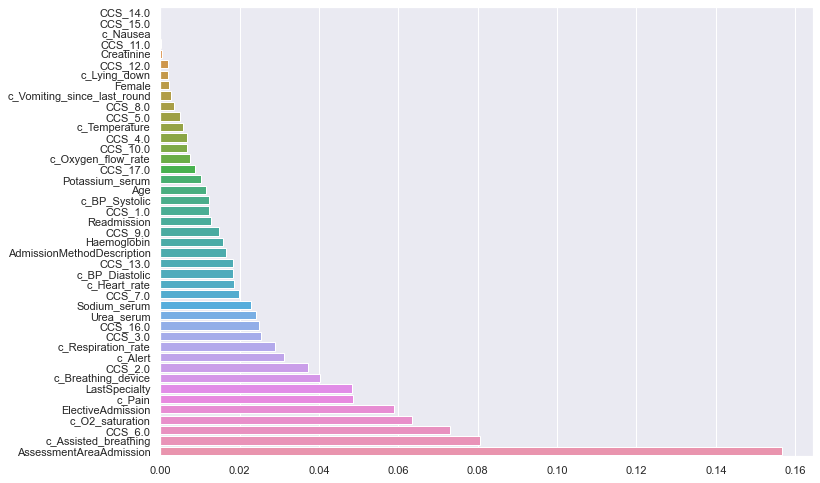

In [105]:
sorted_idx = tabnet_model.feature_importances_.argsort()
sns.barplot(x=tabnet_model.feature_importances_[sorted_idx], y=X.columns[sorted_idx])


In [106]:
first_idx = np.argmax(tabnet_model.predict(X_test) == 1)
explain_matrix, masks = tabnet_model.explain(X_test[first_idx : first_idx + 1])
list(sorted(zip(X.columns, explain_matrix[0]), key=lambda x: x[1]))


[('Female', 0.0),
 ('Age', 0.0),
 ('Haemoglobin', 0.0),
 ('Urea_serum', 0.0),
 ('Potassium_serum', 0.0),
 ('Creatinine', 0.0),
 ('c_Breathing_device', 0.0),
 ('c_O2_saturation', 0.0),
 ('c_Oxygen_flow_rate', 0.0),
 ('c_Temperature', 0.0),
 ('c_Lying_down', 0.0),
 ('c_BP_Systolic', 0.0),
 ('c_Alert', 0.0),
 ('c_Pain', 0.0),
 ('c_Nausea', 0.0),
 ('c_Vomiting_since_last_round', 0.0),
 ('CCS_1.0', 0.0),
 ('CCS_3.0', 0.0),
 ('CCS_4.0', 0.0),
 ('CCS_5.0', 0.0),
 ('CCS_6.0', 0.0),
 ('CCS_7.0', 0.0),
 ('CCS_8.0', 0.0),
 ('CCS_9.0', 0.0),
 ('CCS_10.0', 0.0),
 ('CCS_11.0', 0.0),
 ('CCS_12.0', 0.0),
 ('CCS_14.0', 0.0),
 ('CCS_15.0', 0.0),
 ('CCS_16.0', 0.0),
 ('CCS_17.0', 0.0),
 ('c_BP_Diastolic', 0.0012692917371168733),
 ('c_Heart_rate', 0.00582614541053772),
 ('LastSpecialty', 0.0533481165766716),
 ('CCS_2.0', 0.14617286622524261),
 ('c_Assisted_breathing', 0.269645094871521),
 ('ElectiveAdmission', 0.3324427902698517),
 ('AdmissionMethodDescription', 0.47590070962905884),
 ('Sodium_serum', 0.8